## Notebook to evaluate tomography reconstruction schemes

### Imports/Function definitions

In [1]:
import matplotlib.pyplot as plt                 # For normal plotting
from mpl_toolkits.mplot3d import proj3d         # For 3D plotting
import numpy as np                              # For maths
from scipy import ndimage                       # For image rotations
from scipy import optimize                      # For function minimization
import astra                                    # For tomography framework
import copy                                     # For deep copying arrays

import RegTomoReconMulti as rtr                 # Modified version of Rob's CS code
import multi_axis                               # My custom functions

Compilation successful


### Full example

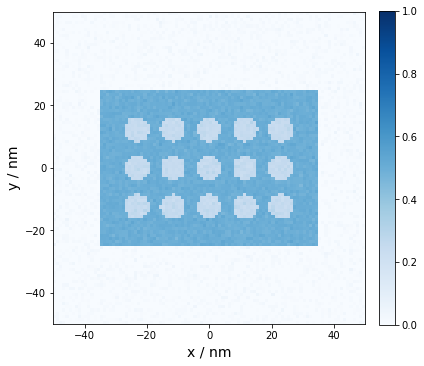

In [17]:
# Generate phantom
#X,Y,Z,P = multi_axis.generate_tri_pris()
#X,Y,Z,P = multi_axis.generate_tetrapod(r_tet=50,r_cyl=6)
X,Y,Z,P = multi_axis.generate_pillar_cavities()
#X,Y,Z,P = multi_axis.generate_sphere()
#X,Y,Z,P = multi_axis.generate_layered_rod()

Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)


# View in 2D
multi_axis.plot_2d(X,Y,Z,Pn)

# Rotate 90 about +x and view again
#Pr = multi_axis.rotate_bulk(Pn,90,0,0)
#multi_axis.plot_2d(X,Y,Z,Pr)

In [18]:
# Generate projection data
angles = multi_axis.generate_angles()
raw_data = multi_axis.generate_proj_data(Pn,angles)
vectors = multi_axis.generate_vectors(angles)

In [23]:
# Perform reconstruction
recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm='TV1')

Started reconstruction... Finished after 1 s


In [24]:
# Match orientation of reconstruction to phantom
recon_vector = multi_axis.reorient_reconstruction(recon)

In [68]:
# Plot reconstruction
def compare_recon_phantom(recon_vector,P,ax=0,ay=0,az=0):
    a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)

    fig= plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.imshow(np.flipud(np.mean(a,axis=2).T))
    ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

    print('Phantom error: ',multi_axis.phantom_error(P,recon_vector),'COD: ', multi_axis.COD(P,recon_vector))

### Testing

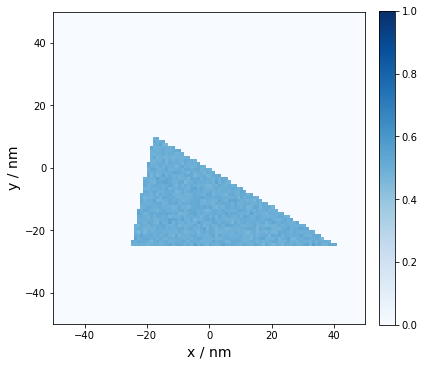

In [166]:
X,Y,Z,P = multi_axis.generate_tri_pris()
Pn = noisy(P,noise_typ='poisson',val_pois=20)
multi_axis.plot_2d(X,Y,Z,Pn)

In [167]:
# Generate different projection angle routines

# normal angles
angles = multi_axis.generate_angles(x_tilt = (-70,70,21),y_tilt = (-70,70,21))

# alternating angles
ADA_angles = []
mid = int(len(angles)/2)
for i in range(mid):
    ADA_angles.append(angles[i])
    ADA_angles.append(angles[mid+i])
    
# random angles
rand_angles = copy.deepcopy(angles)
np.random.shuffle(rand_angles)

# for i in range(len(angles)):
#     print(angles[i],'\t',ADA_angles[i],'\t',rand_angles[i])

all_angles = [angles,ADA_angles,rand_angles]

In [168]:
# Generate projection data

all_raw_data = []
all_vectors = []

for i, angs in enumerate(all_angles):
    raw_data = multi_axis.generate_proj_data(P,angs)
    vectors = multi_axis.generate_vectors(angs)
    all_raw_data.append(raw_data)
    all_vectors.append(vectors)

In [169]:
# Reconstruct

all_recons = []
for i in range(3):
    recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm='SIRT3D_CUDA')
    recon_vector = multi_axis.reorient_reconstruction(recon)
    all_recons.append(recon_vector)

0.5992456016321461

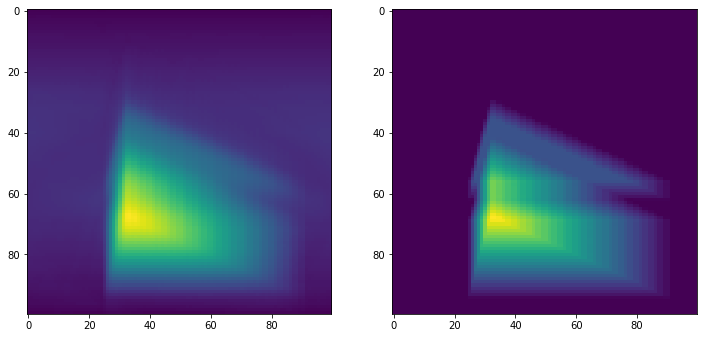

In [172]:
# Plot reconstruction
x = 2
ax,ay,az = 40,0,0
a = multi_axis.rotate_bulk(all_recons[x],ax,ay,az)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(all_recons[x],P))
e = opt.fun
e2 = e
e

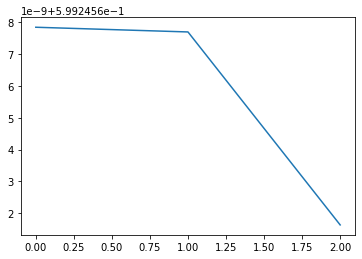

In [173]:
plt.plot([e0,e1,e2])

In [175]:
e0,e1,e2

(0.5992456078433395, 0.599245607695481, 0.5992456016321461)

### Experiments

In [55]:
# for different number of projections
# for different projections schemes
# for different ordering?
# for different reconstruction algorithms
# for different error metrics
# for different noise levels

In [56]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_tri_pris()

In [ ]:
noise_levels = [0,3,10,20,40]
num_proj = [10,20,40,100,150]
tilt_range = [30,70,90]
algs = ['SIRT3D_CUDA','BP3D_CUDA','TV1']

results = np.zeros((5,3,5,3,5,2))

for i_noise,noise in enumerate(noise_levels):
    if noise == 0:
        Pn = copy.deepcopy(P)
    else:
        Pn = noisy(P,noise_typ='poisson',val_pois=noise)
    
    for i_tilt,t in enumerate(tilt_range):
        all_angles = []
        # generate projection data
        for i_proj,num in enumerate(num_proj):
            print(noise,t,num)
            # single axis
            angles_single = multi_axis.generate_angles(x_tilt = (-t,t,num))

            # dual axis
            angles_dual = multi_axis.generate_angles(x_tilt = (-t,t,int(num/2)),y_tilt = (-t,t,int(num/2)))

            # alternating dual
            ADA_angles = []
            mid = int(num/2)
            for i in range(mid):
                ADA_angles.append(angles_dual[i])
                ADA_angles.append(angles_dual[mid+i])

            # random order dual
            rand_dual_angles = copy.deepcopy(angles)
            np.random.shuffle(rand_dual_angles)

            # random angle
            angles_rand = multi_axis.generate_angles(x_tilt=None,n_random=num)

            all_angles = [angles_single, angles_dual, ADA_angles, rand_dual_angles, angles_rand]
            all_raw_data = []
            all_vectors = []
            
            for i_alg,alg in enumerate(algs):
                for i, angs in enumerate(all_angles):
                    raw_data = multi_axis.generate_proj_data(Pn,angs)
                    vectors = multi_axis.generate_vectors(angs)
                    all_raw_data.append(raw_data)
                    all_vectors.append(vectors)

                all_recons = []
                for i in range(len(all_angles)):
                    recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm=alg)
                    recon_vector = multi_axis.reorient_reconstruction(recon)
                    all_recons.append(recon_vector)
                    
                for i_scheme,r in enumerate(all_recons):
                    cod = COD(P,r)
                    pe = phantom_error(P,r)
                    results[i_noise,i_tilt,i_proj,i_alg,i_scheme,0] = cod
                    results[i_noise,i_tilt,i_proj,i_alg,i_scheme,0] = pe

np.save('try1.npy',results)                    

0 30 10
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
0 30 20
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
0 30 40
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
0 30 100
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 3 s
0 30 150
Started reconstruction... Finished after 2 s
Started recon

In [26]:
noise_levels = [0,3,10,20,40]
algs = ['SIRT3D_CUDA','BP3D_CUDA','TV1']
t = 70
num = 71
results = np.zeros((5,3,5,2))

for i_noise,noise in enumerate(noise_levels):
    print('noise level: ', noise)
    if noise == 0:
        Pn = copy.deepcopy(P)
    else:
        Pn = noisy(P,noise_typ='poisson',val_pois=noise)

    # single axis
    angles_single = multi_axis.generate_angles(x_tilt = (-t,t,num))

    # dual axis
    angles_dual = multi_axis.generate_angles(x_tilt = (-t,t,int(num/2)),y_tilt = (-t,t,int(num/2)))

    # alternating dual
    ADA_angles = []
    mid = int(num/2)
    for i in range(mid):
        ADA_angles.append(angles_dual[i])
        ADA_angles.append(angles_dual[mid+i])

    # random order dual
    rand_dual_angles = copy.deepcopy(angles_dual)
    np.random.shuffle(rand_dual_angles)

    # random angle
    angles_rand = multi_axis.generate_angles(x_tilt=None,n_random=num)

    all_angles = [angles_single, angles_dual, ADA_angles, rand_dual_angles, angles_rand]
    all_raw_data = []
    all_vectors = []
    
    for i, angs in enumerate(all_angles):
        raw_data = multi_axis.generate_proj_data(Pn,angs)
        vectors = multi_axis.generate_vectors(angs)
        all_raw_data.append(raw_data)
        all_vectors.append(vectors)
        print('scheme: ',i)
    
    for i_alg,alg in enumerate(algs):
        all_recons = []
        for i in range(len(all_angles)):
            recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm=alg,niter=20)
            recon_vector = multi_axis.reorient_reconstruction(recon)
            all_recons.append(recon_vector)

        for i_scheme,r in enumerate(all_recons):
            cod = COD(P,r)
            pe = phantom_error(P,r)
            results[i_noise,i_alg,i_scheme,0] = cod
            results[i_noise,i_alg,i_scheme,1] = pe
            
        np.save('tripris_t70_n71_5noise_5scheme.npy',results)

0
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
3
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
10
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
20
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 2 s
40
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1

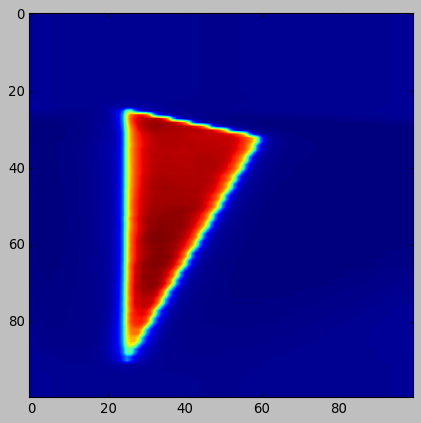

In [95]:
plt.imshow(np.mean(all_recons[0],axis=2))

(-2, 42)

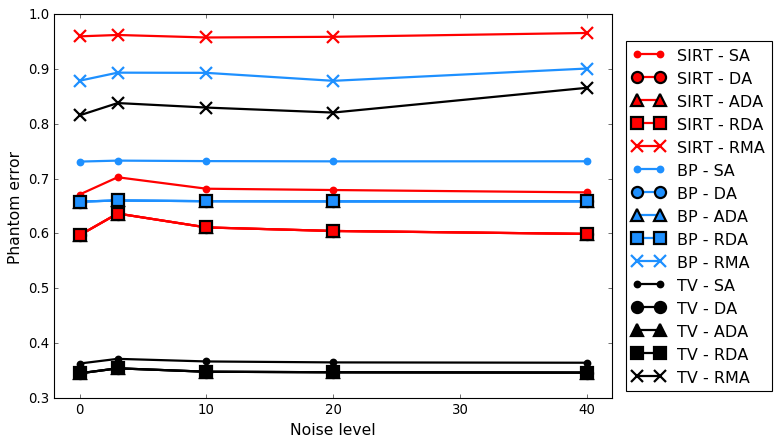

In [86]:
res_load = np.load('tripris_t70_n71_5noise_5scheme.npy')

import matplotlib as mpl
plt.style.use('classic')
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 2
fig = plt.figure(figsize=(9,6),facecolor='w')


noise_levels = [0,3,10,20,40]
algs = ['SIRT','BP','TV']
schemes = ['SA','DA','ADA','RDA','RMA']

cols = ['r','dodgerblue','k']
markers = ['.','o','^','s','x']

for i_alg,alg in enumerate(algs):
    col = cols[i_alg]
    for i_scheme,scheme in enumerate(schemes):
        marker=markers[i_scheme]
        res = res_load[:,i_alg,i_scheme,1]
        label = alg+ ' - ' + scheme
        plt.plot(noise_levels,res,label=label,color=col,marker=marker)

plt.xlabel('Noise level',fontsize=14)
plt.ylabel('Phantom error',fontsize=14)
plt.legend(bbox_to_anchor=(1.3,.95))
plt.xlim([-2,42])

In [156]:
# try again

X,Y,Z,P = multi_axis.generate_tri_pris()
t = 70
num = 35
noise_levels = [0.1,1,10,100]
results = []
for n in noise_levels:
    Pn = noisy(P,noise_typ='poisson',val_pois=n)
    
    angles_x = multi_axis.generate_angles(x_tilt = (-t,t,num))
    angles_y = multi_axis.generate_angles(x_tilt = None,y_tilt = (-t,t,num))
    
    angs = angles_x
    raw_data_x = multi_axis.generate_proj_data(Pn,angs)
    vectors = multi_axis.generate_vectors(angs)
    recon = multi_axis.generate_reconstruction(raw_data_x,vectors,algorithm='TV1',niter=20)
    recon_x = multi_axis.reorient_reconstruction(recon)

    angs = angles_y
    raw_data_y = multi_axis.generate_proj_data(Pn,angs)
    vectors = multi_axis.generate_vectors(angs)
    recon = multi_axis.generate_reconstruction(raw_data_y,vectors,algorithm='TV1',niter=20)
    recon_y = multi_axis.reorient_reconstruction(recon)
    
    recon_xy = np.mean([recon_x,recon_y],axis=0)

    raw_data_dual = np.concatenate((raw_data_x,raw_data_y),axis=1)
    angs = np.concatenate((angles_x,angles_y))
    vectors = multi_axis.generate_vectors(angs)
    recon = multi_axis.generate_reconstruction(raw_data_dual,vectors,algorithm='TV1',niter=20)
    recon_dual = multi_axis.reorient_reconstruction(recon)
    
    cods = COD(P,recon_x),COD(P,recon_y),COD(P,recon_xy),COD(P,recon_dual)
    pes = phantom_error(P,recon_x),phantom_error(P,recon_y),phantom_error(P,recon_xy),phantom_error(P,recon_dual)
    results.append([cods,pes])
    np.save('Parameter tests/4dual_4noises.npy', results)

Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 3 s
Started reconstruction... Finished after 4 s


In [138]:
np.shape(res_load)

(4, 2, 4)

(0.08, 120)

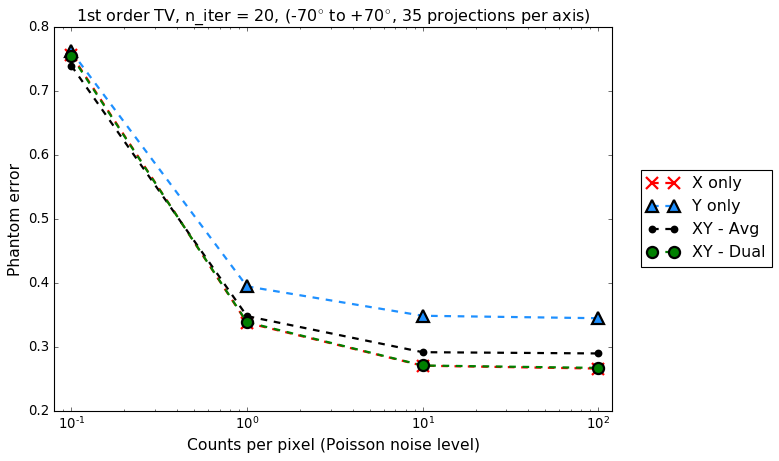

In [165]:
res_load = np.load('Parameter tests/4dual_4noises.npy')

import matplotlib as mpl
plt.style.use('classic')
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 2
fig = plt.figure(figsize=(9,6),facecolor='w')


noise_levels = [0.1,1,10,100]
schemes = ['X only','Y only','XY - Avg', 'XY - Dual']

cols = ['r','dodgerblue','k','g']
markers = ['x','^','.','o']

for i_scheme,scheme in enumerate(schemes):
    col=cols[i_scheme]
    res = res_load[:,1,i_scheme]
    label = scheme
    marker = markers[i_scheme]
    plt.plot(noise_levels,res,'--o',label=label,color=col,alpha=1,marker=marker)

plt.xlabel('Counts per pixel (Poisson noise level)',fontsize=14)
plt.xscale('log')
plt.ylabel('Phantom error',fontsize=14)
plt.legend(bbox_to_anchor=(1.3,.65))
plt.title('1st order TV, n_iter = 20, (-70$^{\circ}$ to +70$^{\circ}$, 35 projections per axis)')
plt.xlim([.08,120])

## Tilt experiments

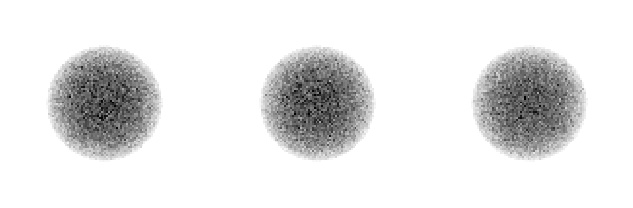

In [3]:
# Plot each phantom

#X,Y,Z,P = multi_axis.generate_tri_pris()
#X,Y,Z,P = multi_axis.generate_tetrapod()
#X,Y,Z,P = multi_axis.generate_pillar_cavities()
X,Y,Z,P = multi_axis.generate_sphere()
#X,Y,Z,P = multi_axis.generate_layered_rod()
Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=1)

fig= plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax2.imshow(np.flipud(np.mean(Pn,axis=2).T),cmap='Greys')
ax1.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(Pn,90,0,0),axis=2).T),cmap='Greys')
ax3.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(Pn,0,90,0),axis=2).T),cmap='Greys')

ax1.axis('off'),ax2.axis('off'),ax3.axis('off')
plt.tight_layout()

In [84]:
# plot collection schemes
%matplotlib qt
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')


angles = multi_axis.generate_angles(mode='dual',x_tilt=(-90,90,25),y_tilt=(-90,90,25),rand=(70,70,50))

bs = []
for i,a in enumerate(final_angles):
    mrot = multi_axis.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1])
    #bs.append(b)
    plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
    ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=20,cmap='coolwarm',alpha=1)
    #ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=i,s=20,cmap='coolwarm',alpha=1)

# ax1.set_yticklabels([])
# ax1.set_xticklabels([])
# ax1.set_zticklabels([])
plt.xlabel('x',fontsize='20')
plt.ylabel('y',fontsize='20')
ax1.set_zlabel('z',fontsize='20')

Text(0.5, 0, 'z')

In [47]:
bs

[array([  0.00000000e+00,   1.00000000e+00,   6.12323400e-17]),
 array([ 0.        ,  0.99144486,  0.13052619]),
 array([ 0.        ,  0.96592583,  0.25881905]),
 array([ 0.        ,  0.92387953,  0.38268343]),
 array([ 0.       ,  0.8660254,  0.5      ]),
 array([ 0.        ,  0.79335334,  0.60876143]),
 array([ 0.        ,  0.70710678,  0.70710678]),
 array([ 0.        ,  0.60876143,  0.79335334]),
 array([ 0.       ,  0.5      ,  0.8660254]),
 array([ 0.        ,  0.38268343,  0.92387953]),
 array([ 0.        ,  0.25881905,  0.96592583]),
 array([ 0.        ,  0.13052619,  0.99144486]),
 array([ 0.,  0.,  1.]),
 array([ 0.        , -0.13052619,  0.99144486]),
 array([ 0.        , -0.25881905,  0.96592583]),
 array([ 0.        , -0.38268343,  0.92387953]),
 array([ 0.       , -0.5      ,  0.8660254]),
 array([ 0.        , -0.60876143,  0.79335334]),
 array([ 0.        , -0.70710678,  0.70710678]),
 array([ 0.        , -0.79335334,  0.60876143]),
 array([ 0.       , -0.8660254,  0.5  

In [55]:
mrot = multi_axis.rotation_matrix(0,0,45,intrinsic=False)
arots=[]
for a in bs:
    arot = np.dot(mrot,a)
    arots.append(arot)

In [83]:
final_angles = []
for A in arots:

    #A = arot[0]
    B = [0,0,1]
    C = B-A

    yaw = np.arctan2(C[0],C[2])*180/np.pi
    padj = np.sqrt(C[0]**2+C[2]**2)
    pitch = np.arctan2(padj,C[1])*180/np.pi
    
#     if yaw > 90:
#         yaw = yaw-90
#     if pitch > 90:
#         pitch = pitch-90
    final_angles.append([yaw,pitch,0])

In [92]:
import numpy as np
from scipy.spatial.transform import Rotation


def normalize(v):
    return v / np.linalg.norm(v)


def find_additional_vertical_vector(vector):
    ez = np.array([0, 0, 1])
    look_at_vector = normalize(vector)
    up_vector = normalize(ez - np.dot(look_at_vector, ez) * look_at_vector)
    return up_vector


def calc_rotation_matrix(v1_start, v2_start, v1_target, v2_target):
    """
    calculating M the rotation matrix from base U to base V
    M @ U = V
    M = V @ U^-1
    """

    def get_base_matrices():
        u1_start = normalize(v1_start)
        u2_start = normalize(v2_start)
        u3_start = normalize(np.cross(u1_start, u2_start))

        u1_target = normalize(v1_target)
        u2_target = normalize(v2_target)
        u3_target = normalize(np.cross(u1_target, u2_target))

        U = np.hstack([u1_start.reshape(3, 1), u2_start.reshape(3, 1), u3_start.reshape(3, 1)])
        V = np.hstack([u1_target.reshape(3, 1), u2_target.reshape(3, 1), u3_target.reshape(3, 1)])

        return U, V

    def calc_base_transition_matrix():
        return np.dot(V, np.linalg.inv(U))

    if not np.isclose(np.dot(v1_target, v2_target), 0, atol=1e-03):
        raise ValueError("v1_target and v2_target must be vertical")

    U, V = get_base_matrices()
    return calc_base_transition_matrix()


def get_euler_rotation_angles(start_look_at_vector, target_look_at_vector, start_up_vector=None, target_up_vector=None):
    if start_up_vector is None:
        start_up_vector = find_additional_vertical_vector(start_look_at_vector)

    if target_up_vector is None:
        target_up_vector = find_additional_vertical_vector(target_look_at_vector)

    rot_mat = calc_rotation_matrix(start_look_at_vector, start_up_vector, target_look_at_vector, target_up_vector)
    is_equal = np.allclose(rot_mat @ start_look_at_vector, target_look_at_vector, atol=1e-03)
    print(f"rot_mat @ start_look_at_vector1 == target_look_at_vector1 is {is_equal}")
    rotation = Rotation.from_dcm(rot_mat)
    return rotation.as_euler(seq="xyz", degrees=True)

get_euler_rotation_angles(np.array(arots[0]),np.array([0,0,1]))

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: v1_target and v2_target must be vertical

In [91]:
arots[0]

array([ -7.07106781e-01,   7.07106781e-01,   6.12323400e-17])

In [60]:
from mathutils import Vector, Quaternion

# normalize B (A and B should both be normalized)
B.normalize()

# cross and dot products of A and B
C = A.cross(B)
D = A.dot(B)

# create and normalize a quaternion
Q = Quaternion((D+1, C[0], C[1], C[2]))
Q.normalize()

# now you can apply the quaternion to your Object
bpy.data.objects['myObject'].rotation_quaternion = Q

# or convert it to euler rotation
Rot = Q.to_euler()

ModuleNotFoundError: No module named 'mathutils'

In [25]:
algs = ['BP3D_CUDA','SIRT3D_CUDA','TV1']

X,Y,Z,P = multi_axis.generate_tetrapod()

Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)

# Generate projection data
angles = multi_axis.generate_angles()
raw_data = multi_axis.generate_proj_data(Pn,angles)
vectors = multi_axis.generate_vectors(angles)

#recon
recons = []
for alg in algs:
    recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm=alg)
    recon_vector = multi_axis.reorient_reconstruction(recon)
    recons.append(recon_vector)

Started reconstruction... Finished after 1 s


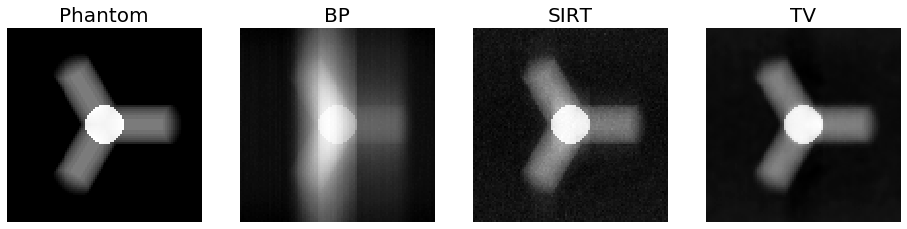

In [34]:
fig= plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
c='Greys_r'
ax1.imshow(np.flipud(np.mean(P,axis=2).T),cmap=c)
ax2.imshow(np.flipud(np.mean(recons[0],axis=2).T),cmap=c)
ax3.imshow(np.flipud(np.mean(recons[1],axis=2).T),cmap=c)
ax4.imshow(np.flipud(np.mean(recons[2],axis=2).T),cmap=c)

ax1.set_title('Phantom',fontsize=20)
ax2.set_title('BP',fontsize=20)
ax3.set_title('SIRT',fontsize=20)
ax4.set_title('TV',fontsize=20)

for ax in [ax1,ax2,ax3,ax4]:
    ax.axis('off')

### Experiment

In [40]:
# Save name for this experiment 
title = r'Parameter tests/pillars_a50_b5_n10_TV1_schemes.npy'

# Generate phantom
X,Y,Z,P = multi_axis.generate_pillar_cavities()
Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)

# Iterate
n = 10
results=[]
a = 50
b = 5
for scheme in ['x','y','dual','quad','sync','dist','rand']:
    angles = multi_axis.generate_angles(mode=scheme,x_tilt=(-a,a,n),y_tilt=(-b,b,n),rand=(a,b,2*n))
    raw_data = multi_axis.generate_proj_data(Pn,angles)
    vectors = multi_axis.generate_vectors(angles)
    recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm='TV1')
    recon_vector = multi_axis.reorient_reconstruction(recon)
    cod = multi_axis.COD(P,recon_vector)
    pe = multi_axis.phantom_error(P,recon_vector)
    results.append([cod,pe])
    
np.save(title,results)

Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 1 s


Text(0.5, 1.0, 'TV reconstruction of cavity pillars')

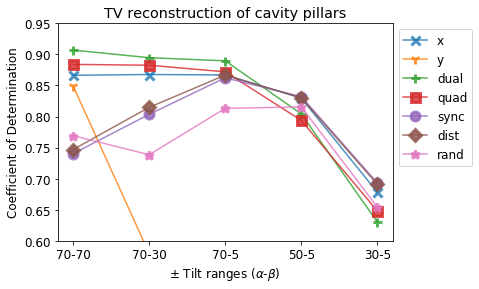

In [71]:
a70b70 = np.load('Parameter tests/pillars_a70_b70_n10_TV1_schemes.npy')
a70b30 = np.load('Parameter tests/pillars_a70_b30_n10_TV1_schemes.npy')
a70b5 = np.load('Parameter tests/pillars_a70_b5_n10_TV1_schemes.npy')
a50b5 = np.load('Parameter tests/pillars_a50_b5_n10_TV1_schemes.npy')
a30b5 = np.load('Parameter tests/pillars_a30_b5_n10_TV1_schemes.npy')
CODs = np.concatenate((a70b70[:,0],a70b30[:,0],a70b5[:,0],a50b5[:,0],a30b5[:,0]))

schemes = ['x','y','dual','quad','sync','dist','rand']
markers = ['x','1','+','s','o','D','*']
for i in range(7):
    y = CODs[i::7]
    plt.plot(np.array(y),marker=markers[i],label=schemes[i],markersize=9,alpha=.8,markeredgewidth=3)
    

plt.legend(bbox_to_anchor=(1,1))
ax = plt.gca()
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['70-70','70-30','70-5','50-5','30-5'])
plt.xlabel(r'$\pm$ Tilt ranges ($\alpha$-$\beta$)')
plt.ylabel('Coefficient of Determination')

plt.rcParams.update({'font.size': 12})
plt.ylim([.6,.95])
plt.title('TV reconstruction of cavity pillars')

In [72]:
def full_tomo(P,Pn,scheme='x',a=70,b=70,n=10,alg='TV1'):
    angles = multi_axis.generate_angles(mode=scheme,x_tilt=(-a,a,n),y_tilt=(-b,b,n),rand=(a,b,2*n))
    raw_data = multi_axis.generate_proj_data(Pn,angles)
    vectors = multi_axis.generate_vectors(angles)
    recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm=alg)
    recon_vector = multi_axis.reorient_reconstruction(recon)
    return [recon_vector,raw_data,angles]

In [73]:
r = full_tomo(P,Pn,scheme='dist')

Started reconstruction... Finished after 3 s


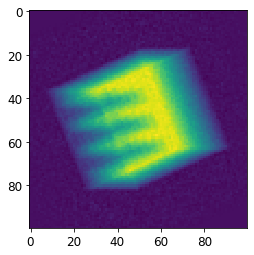

In [100]:
plt.imshow(r[1][:,60,:])

Phantom error:  0.46923801609502674 COD:  0.747416432327


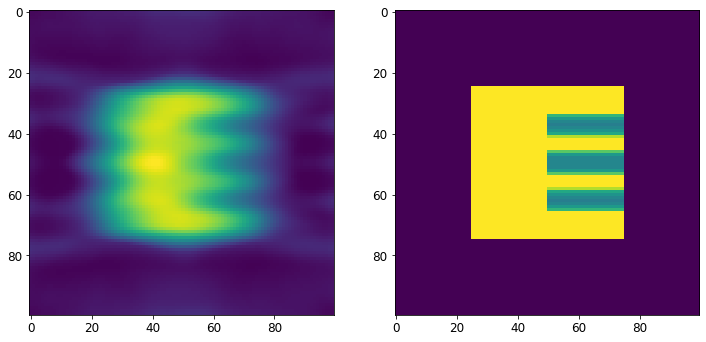

In [104]:
compare_recon_phantom(r[0],P,ax=0,ay=90,az=0)

In [112]:
X,Y,Z,P = multi_axis.generate_sphere()

In [131]:
angles = []
for a in np.linspace(0,30,5):
    angles.append([30,a,0])

raw_data = multi_axis.generate_proj_data(P,angles)
vectors = multi_axis.generate_vectors(angles)
recon = multi_axis.generate_reconstruction(raw_data,vectors)
recon_vector = multi_axis.reorient_reconstruction(recon)


Phantom error:  0.9137416855800853 COD:  0.35931828476


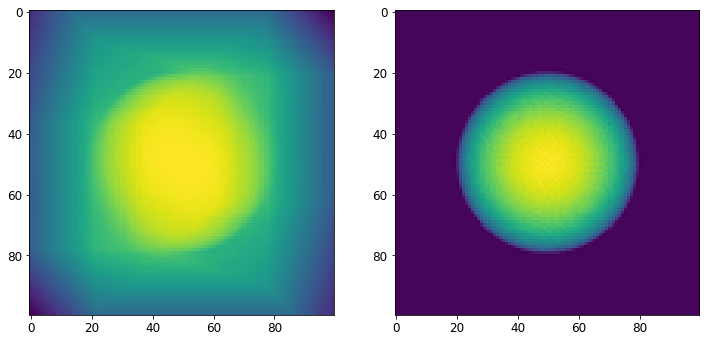

In [134]:
compare_recon_phantom(recon_vector,P,ax=30,ay=30)

In [118]:
angles

[[0.0, 0, 0], [7.5, 0, 0], [15.0, 0, 0], [22.5, 0, 0], [30.0, 0, 0]]

Started reconstruction... Finished after 10 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 2 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s


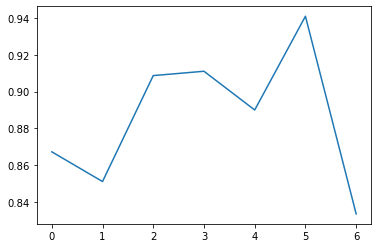

In [2]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_pillar_cavities()
Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)

# Iterate
n = 10
results=[]
a = 70
b = 70
for i,scheme in enumerate(['x','y','dual','quad','sync','dist','rand']):
    if i == 5:
        angles = multi_axis.generate_angles(mode=scheme,x_tilt=(-a,a,5),y_tilt=(-b,b,5),rand=(a,b,2*n))
    else:
        angles = multi_axis.generate_angles(mode=scheme,x_tilt=(-a,a,n),y_tilt=(-b,b,n),rand=(a,b,2*n))
    
    raw_data = multi_axis.generate_proj_data(Pn,angles)
    vectors = multi_axis.generate_vectors(angles)
    recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm='TV1')
    recon_vector = multi_axis.reorient_reconstruction(recon)
    cod = multi_axis.COD(P,recon_vector)
    pe = multi_axis.phantom_error(P,recon_vector)
    results.append([cod,pe])
    
plt.plot(np.array(results)[:,0])

In [52]:
def rotation_matrix(ax,ay,az,intrinsic = True):
    """ 
    Generate 3D rotation matrix from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """
        
    ax = ax * np.pi/180
    Cx = np.cos(ax)
    Sx = np.sin(ax)
    mrotx = np.array([[1,0,0],[0,Cx,-Sx],[0,Sx,Cx]])
    
    ay = ay * np.pi/180
    Cy = np.cos(ay)
    Sy = np.sin(ay)
    mroty = np.array([[Cy,0,Sy],[0,1,0],[-Sy,0,Cy]])
    
    az = az * np.pi/180
    Cz = np.cos(az)
    Sz = np.sin(az)
    mrotz = np.array([[Cz,-Sz,0],[Sz,Cz,0],[0,0,1]])
    
    if intrinsic == True:
        mrot = mrotz.dot(mroty).dot(mrotx)
    else:
        # To define mrot in an extrinsic space, matching
        # our desire for intrinsic rotation, we need
        # to swap the order of the applied rotations
        mrot = mrotx.dot(mroty).dot(mrotz)
    return mrot

def get_astravec(ax,ay,az):
    """ Given angles in degrees, return r,d,u,v as a concatenation
    of four 3-component vectors"""
    # Since we us flipud on y axis, ay needs reversing for desired behaviour
    ay = -ay 
    
    # centre of detector
    d = [0,0,0]
    
    # 3D rotation matrix - EXTRINSIC
    mrot = np.array(rotation_matrix(ax,ay,az,intrinsic=False))
    
    # ray direction r
    r = mrot.dot([0,0,1])*-1 # -1 to match astra definitions
    # u (det +x)
    u = mrot.dot([1,0,0])
    # v (det +y)
    v = mrot.dot([0,1,0])

    return np.concatenate((r,d,u,v))

def generate_proj_data(P,angles):
    """ Returns projection dataset given phantom P
    and 3D projection angles list.
    
    Output is normalised and reshaped such that the
    projection slice dimension is in the middle, so as
    to be compatible with astra."""
    P_projs = []
    
    for i in range(len(angles)):
        ax,ay,az = angles[i]
        P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
        P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T) #flip/T match data shape to expectations
        P_projs.append(P_rot_proj) 
        
    # Prepare projections for reconstruction
    raw_data = np.array(P_projs)
    raw_data = raw_data -  raw_data.min()
    raw_data = raw_data/raw_data.max()
    raw_data = np.transpose(raw_data,axes=[1,0,2]) # reshape so proj is middle column
        
    return raw_data
      
def generate_vectors(angles):
    """ Converts list of 3D projection angles into
    list of astra-compatible projection vectors,
    with [r,d,u,v] vectors on each row. """
    vectors = []
    for [ax,ay,az] in angles:
        vector = get_astravec(ax,ay,az)
        vectors.append(vector)
    
    return vectors

def generate_reconstruction(raw_data,vectors, algorithm = 'SIRT3D_CUDA', niter=10, weight = 0.01,
                            balance = 1, steps = 'backtrack'):
    """ Chooise from 'SIRT3D_CUDA','FP3D_CUDA','BP3D_CUDA','CGLS3D_CUDA' or 'TV1'"""
    # Astra default algorithms
    if algorithm in ['SIRT3D_CUDA','FP3D_CUDA','BP3D_CUDA','CGLS3D_CUDA']:
        # Load data objects into astra C layer
        proj_geom = astra.create_proj_geom('parallel3d_vec',np.shape(raw_data)[0],np.shape(raw_data)[2],np.array(vectors))
        projections_id = astra.data3d.create('-sino', proj_geom, raw_data)
        vol_geom = astra.creators.create_vol_geom(np.shape(raw_data)[0], np.shape(raw_data)[0],
                                                  np.shape(raw_data)[2])
        reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
        alg_cfg = astra.astra_dict(algorithm)
        alg_cfg['ProjectionDataId'] = projections_id
        alg_cfg['ReconstructionDataId'] = reconstruction_id
        algorithm_id = astra.algorithm.create(alg_cfg)

        astra.algorithm.run(algorithm_id,iterations=niter)
        recon = astra.data3d.get(reconstruction_id)
    
    # CS TV using RTR
    if algorithm == 'TV1':
        data = rtr.tomo_data(raw_data, np.array(vectors), degrees=True,
                    tilt_axis=0, stack_dim=1)

        vol_shape = (data.shape[0],data.shape[0],data.shape[2])
        projector = data.getOperator(vol_shape=vol_shape,
                                    backend='astra',GPU=True)
        alg = rtr.TV(vol_shape, order=1)
        
        recon = alg.run(data=data,op=projector, maxiter=niter, weight=weight,
                balance=balance, steps=steps,
                callback=None)
    
    return recon

def reorient_reconstruction(r):
    # Swap columns back to match orientation of phantom
    r = np.transpose(r,[2,1,0]) # Reverse column order
    r = r[:,::-1,:] # Reverse the y data # CHANGE removed this
    r = r -  r.min() # normalise
    r = r/r.max()

    recon_vector = copy.deepcopy(r)
    
    return recon_vector

Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s
Started reconstruction... Finished after 1 s


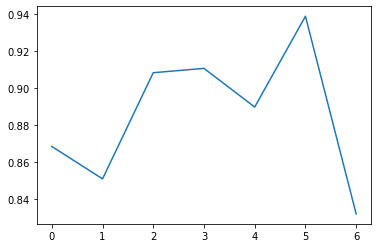

In [49]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_pillar_cavities()
Pn = multi_axis.noisy(P,noise_typ='poisson',val_pois=300)
Pn = multi_axis.noisy(Pn,noise_typ='gauss',g_var=.01)
Pn = multi_axis.noisy(Pn,noise_typ='s&p',p_sp=0.005)

# Iterate
n = 10
results2=[]
a = 70
b = 70
for i,scheme in enumerate(['x','y','dual','quad','sync','dist','rand']):
    if i == 5:
        angles = multi_axis.generate_angles(mode=scheme,x_tilt=(-a,a,5),y_tilt=(-b,b,5),rand=(a,b,2*n))
    else:
        angles = multi_axis.generate_angles(mode=scheme,x_tilt=(-a,a,n),y_tilt=(-b,b,n),rand=(a,b,2*n))
    
    raw_data = generate_proj_data(Pn,angles)
    vectors = generate_vectors(angles)
    recon = generate_reconstruction(raw_data,vectors,algorithm='TV1')
    recon_vector = reorient_reconstruction(recon)
    cod = multi_axis.COD(P,recon_vector)
    pe = multi_axis.phantom_error(P,recon_vector)
    results2.append([cod,pe])
    
plt.plot(np.array(results2)[:,0])

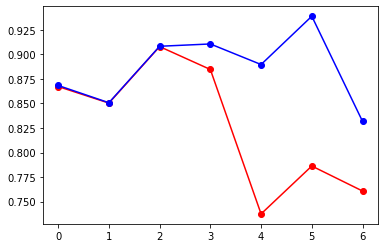

In [51]:
plt.plot(np.array(results)[:,0],'r-o')
plt.plot(np.array(results2)[:,0],'b-o')